In [1]:
import spaudiopy as spa
import pyfar as pf
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import soundfile as sf
import glob
# import spharpy

Generelle Idee meines Ansatzes:
- Ausgangspunkt: Spherical Harmonics
    - SH mit virtuellen LS decodieren oder
    - SH per Beamforming extrahieren
- Berechnung der Parameter
- Plot
- Profit

In [17]:
# Definition von Variablen 
fs = 44100
# audio,fs = sf.read("HOA\HOA_A10p_S00_R00_CH01.wav")

# Definition der Evaluationszeiträume
tl = 15
tu = 100

tl = round((tl*(10**(-3)))*fs)
tu = round((tu*(10**(-3)))*fs)


# Erstellung der Multifile-IR
# RIR_Mf = np.zeros((16,224910))
# RIR_HOA = np.zeros((16,224910))
# n = 0
# HOA_files = np.zeros(16)

# for i in [f'{i:>02}' for i in range(1, 16)]:
#     HOA_files[n] = str("HOA\HOA_A10p_S00_R00_CH" + i + ".wav")
#     # RIR_Mf[n] = spa.sig.MonoSignal.from_file("HOA\HOA_A10p_S00_R00_CH" + i + ".wav", fs)       # RIR, fs = 48000)
#     n = n+1

# RIR_HOA = spa.io.load_audio(HOA_files)

# for i in [f'{i:>02}' for i in range(1, 16)]:
#     RIR[n] = spa.sig.MonoSignal.from_file("HOA\HOA_A10p_S00_R00_CH" + i + ".wav")
#     n = n+1

# sp.io.wavfile.write('RIR_MultiSignal.wav', 44100, RIR)
# RIR_Mf = spa.sig.MultiSignal.from_file('RIR_MultiSignal.wav')       # RIR, fs = 48000)

# load all Files------------------------------
# HOA_paths = glob.glob("HOA\*.wav")
# print(len(HOA_paths), "HOA files found. = 3rd order ambisonics")
# HOAS = spa.io.load_audio(HOA_paths)
# #--------------------------------------

# load only Ambisonics B-Format components
n = 0
HOA_files_b = ["" for x in range(4)]

for i in [f'{i:>02}' for i in range(1, 5)]:
    HOA_files_b[n] = "HOA\HOA_A10p_S00_R00_CH" + i + ".wav"
    n = n+1

MultiSig = spa.io.load_audio(HOA_files_b)
ambi_b = spa.sig.AmbiBSignal.sh_to_b(MultiSig)

In [3]:
def loadAudio(files, B_format = True):
    """
    Load spherical harmonics as audiofiles and define as spaudiopy.sig. ... .

    Parameters
    ----------
    files : int, float
        file paths
    B_format : int, float, optional
        define if input signal should be formatted as ambisonic B-format

    Returns
    -------
    signal : int, float
        audio signal in form of an spaudiopy object
    sampling rate : int, float
        sampling rate 
    """
    return signal, fs

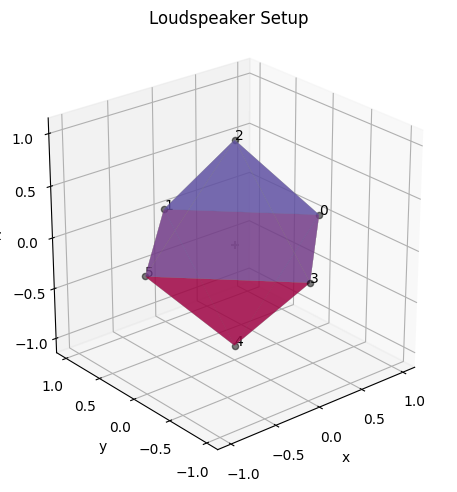

In [4]:
# Berechnung der Schalleinfallsrichtungen + Energien über LS:

# Definition des Lautsprechersetups
ls_setup = spa.decoder.LoudspeakerSetup([1,0,0,0,0,-1], [0,1,0,-1,0,0], [0,0,1,0,-1,0])
ls_setup.ambisonics_setup()
ls_setup.ambisonics_hull.show()
# Decoden des Ambisonics-Signals in Einzelsignale
ls_sig = spa.decoder.allrad(HOAS.get_signals(), ls_setup, 3)

# Berechnung der Richtungsenergien
front = sum(ls_sig[0, tl:tu])
back = sum(ls_sig[5, tl:tu])
top = sum(ls_sig[2, tl:tu])
left = sum(ls_sig[1, tl:tu])
right = sum(ls_sig[3, tl:tu])

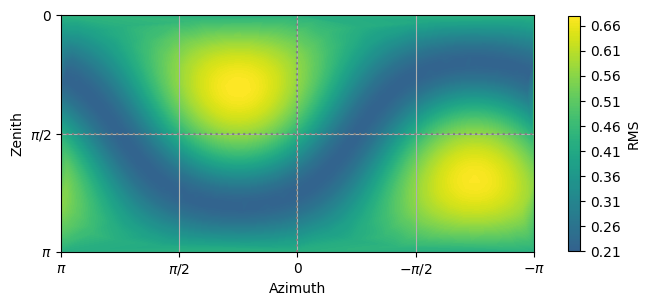

In [5]:
# Berechnung der Schalleinfallsrichtungen + Energien über Beamforming:

# Definieren des Beamformers in Nierenform (top, links, rechts, hinten)
beam_def = spa.parsa.sh_beamformer_from_pattern('max_rE', 3, [0,1.5*np.pi,0.5*np.pi, np.pi], [0.5*np.pi, 0, 0, 0])
beam_sig = spa.parsa.sh_beamform(beam_def,HOAS)
spa.plot.sh_rms_map(beam_def) # (!!)stimmt noch nicht(!!)

# (evtl. eher sph.design_sph_filterbank() nutzen und mit sph.sph_filterbank_reconstruction_factor() korrigieren)

# Berechnung der Richtungsenergien
# front = sum(beam_sig[4, tl:tu])
back = sum(beam_sig[3, tl:tu])
top = sum(beam_sig[0, tl:tu])
left = sum(beam_sig[1, tl:tu])
right = sum(beam_sig[2, tl:tu])

## was ist mit spa.sph.inverse_sht()???


C:\Users\moinm\AppData\Local\Temp\ipykernel_11068\125932985.py:8: RuntimeWarning: divide by zero encountered in log10
  coord_cart_r = coord_cart * np.log10(vek_r)
C:\Users\moinm\AppData\Local\Temp\ipykernel_11068\125932985.py:8: RuntimeWarning: invalid value encountered in multiply
  coord_cart_r = coord_cart * np.log10(vek_r)
C:\Users\moinm\AppData\Local\Temp\ipykernel_11068\125932985.py:43: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(ambi_b_time[0:t_ev2], 10*np.log10(ambi_b_signal[0, 0:t_ev2]**2))


Text(0, 0.5, 'L in dB')

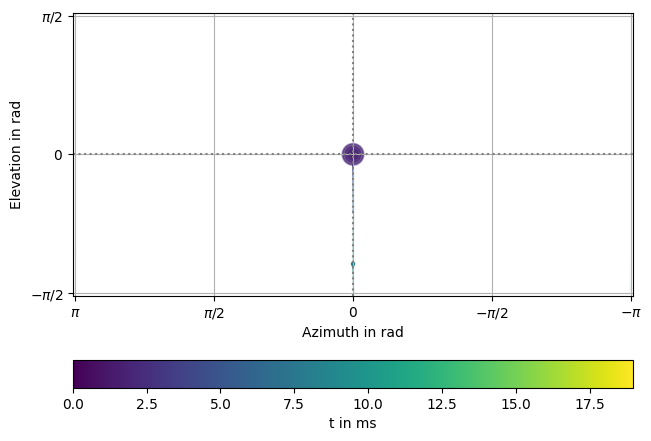

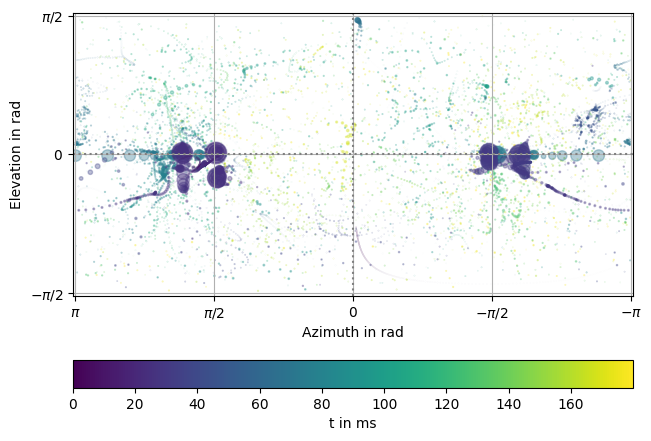

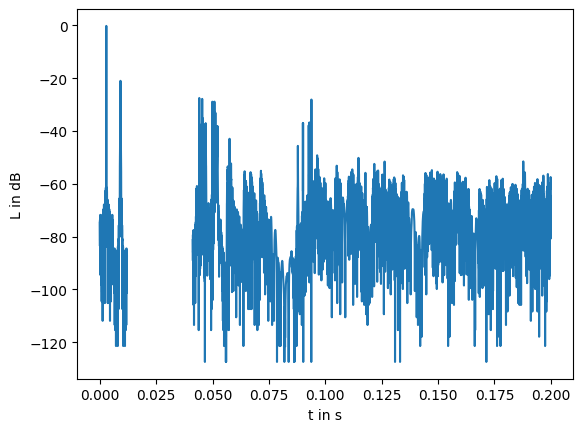

In [18]:
# Berechnung der Schalleinfallsrichtungen über Pseudointensität (IRIS)
vek_azi, vek_zen, vek_r = spa.parsa.pseudo_intensity(ambi_b, win_len=3, f_bp = (63,4000)) # win_len = 441 = 1 ms Mittelung
# vek_r = np.log10(np.abs(vek_r))

# Berechnung der Intensitätsvektoren
# coord_ps_i = spa.utils.sph2cart(vek_azi, vek_zen, vek_r)
coord_cart = spa.utils.dir2cart(vek_azi, vek_zen)
coord_cart_r = coord_cart * np.log10(vek_r)


## Plot der Intensitätsvektoren
# Definition des Evaluationszeitraumes
t_start = int(ambi_b.fs * 0.001)
t_ev = int(ambi_b.fs * 0.02)
t_ev2 = int(ambi_b.fs * 0.2)

# Extraktion der Vektorendpunkte (benötigt, für Zeitoptimierung)
x_pl = coord_cart_r[0]
y_pl = coord_cart_r[1]
z_pl = coord_cart_r[2]

# Plot der Vektoren
# ax = plt.axes(projection='3d')
# for i in range(t_ev, t_ev2):
#     ax.plot3D([0,x_pl[i]],[0,y_pl[i]],[0,z_pl[i]],'orange')

# for i in range(0, t_ev):
#     ax.plot3D([0,x_pl[i]],[0,y_pl[i]],[0,z_pl[i]],'red')

# ax.plot3D([0,10],[0,0],[0,0],'green')

# # ax.axes.set_xlim3d(left=-1, right=1)
# # ax.axes.set_ylim3d(bottom=-1, top=1)
# # ax.axes.set_zlim3d(bottom=-1, top=1)

# Plot der Schalleinfallsrichtungen in azi/zen/r/t
spa.plot.doa(vek_azi[t_start:t_ev], vek_zen[t_start:t_ev], vek_r[t_start:t_ev],  fs = ambi_b.fs)
spa.plot.doa(vek_azi[t_ev:t_ev2], vek_zen[t_ev:t_ev2],vek_r[t_ev:t_ev2], fs = ambi_b.fs)

ambi_b_signal = ambi_b.get_signals()
ambi_b_time = np.linspace(0,len(ambi_b_signal[0])/ambi_b.fs,len(ambi_b_signal[0]))
fig, ax1 = plt.subplots()
ax1.plot(ambi_b_time[0:t_ev2], 10*np.log10(ambi_b_signal[0, 0:t_ev2]**2))
ax1.set_xlabel('t in s')
ax1.set_ylabel('L in dB')
# bzw. über SDM
# ... viele Wege führen nach Rom und manchmal sogar zur CD_ROM

In [44]:
def pseudoIntensDOA(MultiSig, win_len, f_bandpass_u, f_bandpass_o, cart = True, log = False):
    """
    Calculate the direction of arrival (DOA) from ambisonic B-Format signal (spaudiopy.sig.AmbiBSignal).


    Parameters
    ----------
    B_format : sig.AmbiBSignal
        Ambisonics B-Format Signal.
    win_len : (n, l)
        Number of samples the direction of arrival (DOA) is estimated (has to be an uneven Number). Acts as a moving average.
    f_bandpass_u : int, float
        Lower cutoff frequency for bandpassing the input signal.
    f_bandpass_u : int, float
        Upper cutoff frequency for bandpassing the input signal.
    cart : Boolean
        Defines if output should be in cartesian coordinates.
    log : Boolean
        Defines if output should be logarithmic or not.
    
    
    Returns
    -------
    DOA : array_like
        direction of arrival.

        If "cart = False" consisting of [vek_azi, vek_zen, vek_r] with:
        vek_azi : array_like
            Azimuth for each time sample.
        vek_zen : array_like
            Zenith for each time sample.
        vek_r : array_like
            Radius for each time sample.

        If "cart = True" consisting of [x, y, z] with:
        x : array_like
            X-coordinate for each time sample.
        y : array_like
            Y-coordinate for each time sample.
        z : array_like
            Z-coordinate for each time sample.
    """
    B_format = spa.sig.AmbiBSignal.sh_to_b(MultiSig)
    
    vek_azi, vek_el, vek_r = spa.parsa.pseudo_intensity(B_format, win_len, f_bp = (f_bandpass_u, f_bandpass_o))

    if cart == True:
        coord_cart = spa.utils.dir2cart(vek_azi, vek_el)
        
        if log == True:
            coord_cart = coord_cart * np.log10(vek_r)
            
        DOA = coord_cart

    if cart == False:
        DOA = [vek_azi, vek_el, vek_r]

        if log == True:
            DOA[2] = np.log10(DOA[2])


    return DOA

In [46]:
def PlotDOACart(DOA, sampling_rate, start, end):
    """
    Plotting the direction of arrival (DOA) defined by the method "pseudoIntensDOA()" on a cartesian map. Only works if cart = True.

    Parameters
    ----------
    DOA : array_like
        Direction of arrival in cartesian coordinates.
    fs : int, float
        Sampling rate.
    start : int, float
        Start of the plotting interval in samples.
    end : int, float
        End of the plotting interval in samples.
    
    Returns
    -------
    DOA : array_like
        direction of arrival consisting of [vek_azi, vek_zen, vek_r] with
    """

    t_start = int(fs * start)
    t_ev = int(fs * end)

    vek_azi = DOA[0]
    vek_el = DOA[1]
    vek_r = DOA[2]

    plot = spa.plot.doa(vek_azi[t_start:t_ev], vek_el[t_start:t_ev], vek_r[t_start:t_ev],  fs= sampling_rate)
    
    return plot

In [53]:
def PlotDOAIRIS(DOA, fs, start, div, end):
    """
    Plotting the direction of arrival (DOA) defined by the method "pseudoIntensDOA()" as single vectors in a 3-dimensional plot. For best results use cart = true in method "pseudoIntensDOA()".

    Parameters
    ----------
    DOA : array_like
        Direction of arrival in cartesian coordinates.
    fs : int, float
        Sampling rate.
    start : int, float
        Start of the plotting interval in samples. !!does not work yet!!
    div : int, float
        Dividing time of the plotting interval in samples. Defines ending time of the red vectors.
    end : int, float
        End of the plotting interval in samples.
    
    Returns
    -------
    DOA : array_like
        direction of arrival consisting of [vek_azi, vek_zen, vek_r] with
    """
    t_start = int(fs * start)
    t_ev = int(fs * div)
    t_ev2 = int(fs * end)

    x_pl = DOA[0]
    y_pl = DOA[1]
    z_pl = DOA[2]

    # Plot der Vektoren
    ax = plt.axes(projection='3d')
    for i in range(t_ev, t_ev2):
        ax.plot3D([0,x_pl[i]],[0,y_pl[i]],[0,z_pl[i]],'orange')

    for i in range(t_start, t_ev):
        ax.plot3D([0,x_pl[i]],[0,y_pl[i]],[0,z_pl[i]],'red')

    ax.plot3D([0,10],[0,0],[0,0],'green')

    ax.axes.set_xlim3d(left=-1, right=1)
    ax.axes.set_ylim3d(bottom=-1, top=1)
    ax.axes.set_zlim3d(bottom=-1, top=1)

    return ax

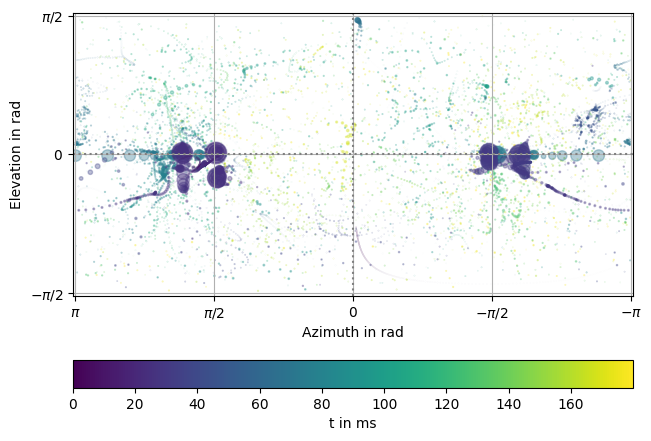

In [54]:
vek_azi, vek_el, vek_r = pseudoIntensDOA(ambi_b, 3, 63, 4000, cart = False, log = False)
fs = ambi_b.fs
ax = PlotDOACart(DOA_sph, fs, 0.02, 0.2)# 0.001, 0.02)


# DOA_cart = pseudoIntensDOA(ambi_b, 3, 63, 4000, cart = True, log = True)
# ax = PlotDOAIRIS(DOA_cart, ambi_b.fs, 0.001, 0.015, 0.02)

In [11]:
# Test mit Gewichtungsmethode aus dem Paper
weights = np.array(([500,-1,-1,720.1,-3.1,1.3,-1.3,-1.3,617.1],[503,0,723.1,0,-532.8,0,0,0,-311.2],[503,0,-723.1,0,-532.8,0,0,0,-311.2],[503,723.1,0,0,535.9,0,0,0,-305.8]))
# weights[0]
ambi_3 = HOAS.get_signals()
ambi_2 = ambi_3[[0,1,2,3,4,5,6,7,8]]
ambi_2_sect = ambi_2[:,tl:tu]

ambi_2_sum = np.zeros(9)
for i in range(9):
    ambi_2_sum[i] = np.sum(ambi_2_sect[i,:])

tlbr_weights = ambi_2_sum * weights

tlbr = np.zeros(4)
for i in range(4):
    tlbr[i] = np.sum(tlbr_weights[i,:])


# TS - Top/Sides(left,right)

TS = 10*np.log10((tlbr[0])**2/(tlbr[1] + tlbr[3])**2)
print('TS = ' + str(TS))

# TH - Top/Horizontal(left,right,back)

TH = 10*np.log10((tlbr[0])**2/(tlbr[1] + tlbr[2] + tlbr[3])**2)
print('TH = ' + str(TH))



TS = -9.895755411213717
TH = -13.791350025954241


In [12]:
# Beschreibung des Parameters

# TS - Top/Sides(left,right)

TS = 10*np.log10((top)**2/(left + right)**2)
print('TS = ' + str(TS))

# TH - Top/Horizontal(left,right,back)

TH = 10*np.log10((top)**2/(left + right + back)**2)
print('TH = ' + str(TH))

TS = 4.232123223259606
TH = 0.7102980421459821


(-1.0, 1.0)

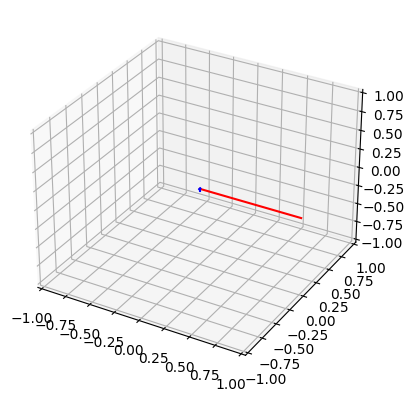

In [13]:

# Darstellung des Parameters

# Vorläufiger Plot der reinen IR
# spa.plot.sh_rms_map(RIR_Mf, title="Raw Spatial Impulse Response (with SH)")

ax = plt.axes(projection='3d')
ax.plot3D([0,1],[0,0],[0,0],'red')
# ax.plot3D([1],[1],[1])
ax.plot3D([0,0],[0,0],[0,top],'blue')
ax.plot3D([0,0],[0,left],[0,0],'blue')
ax.plot3D([0,0],[0,-right],[0,0],'blue')

ax.axes.set_xlim3d(left=-1, right=1) 
ax.axes.set_ylim3d(bottom=-1, top=1) 
ax.axes.set_zlim3d(bottom=-1, top=1)

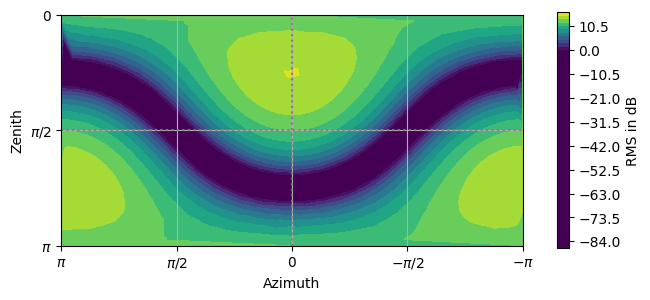

In [14]:
N_sph = 1 # Ambisonics order
fs = 48000

in_sig = np.ones(4)
# in_sig = spa.sph.bandlimited_dirac(1, )

# defining steering directions of the beampattern
vec = np.array([[-1,0,0],[0,-1,0],[0,1,0],[0,0,1]]) #back, left, right, top

# conversion of vec: [x,y,z] to dir: [azi, zen]
dirs = spa.utils.vec2dir(vec) 

azi_steer = dirs[:,0]
zen_steer = dirs[:,1]

w_nm = spa.parsa.sh_beamformer_from_pattern('max_rE', N_sph,
                                          azi_steer, zen_steer)



x_nm = in_sig
y = spa.parsa.sh_beamform(w_nm, x_nm)

spa.plot.sh_rms_map(y, True)


